In [1]:
# !pip install ultralytics
# !pip install supervision

In [2]:
import numpy as np
from ultralytics import YOLO
from core import process_video, to_center_base
from supervision.geometry.core import Point
from supervision.draw.utils import draw_text
from supervision.utils.video import VideoInfo
from supervision.draw.color import ColorPalette
from supervision.detection.core import Detections
from supervision.utils.notebook import plot_image
from supervision.detection.annotate import BoxAnnotator
from supervision.utils.video import get_video_frames_generator

In [3]:
source_video_path = "./datasets/videos/Traffic.mp4"
target_video_path = "./datasets/videos/Traffic_result.mp4"

In [4]:
model = YOLO("yolov8x.pt") # Available model weights: yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt

100%|██████████| 131M/131M [00:00<00:00, 143MB/s]


In [5]:
# The ids of the desired classes.

class_id = [1, 2, 3, 5, 7]

In [6]:
# Coordinates of the areas to be estimated.

R1 = np.array([[10, 900], [275, 435], [610, 30], [680, 30], [475, 435], [337, 900]])
R2 = np.array([[350, 900], [480, 435], [685, 30], [750, 30], [675, 435], [675, 900]])
R3 = np.array([[705, 900], [695, 435], [755, 30], [823, 30], [875, 435], [1020, 900]])
R4 = np.array([[1030, 900], [880, 435], [825, 30], [880, 30], [1055, 435], [1330, 900]])
R5 = np.array([[1340, 900], [1060, 435], [885, 30], [940, 30], [1225, 435], [1650, 900]])

Rpolygons = list((R1, R2, R3, R4, R5))

In [7]:
# Coordinates where the number of vehicles in the area will be written.

text_coord = {"0": [1725, 25, 1900, 200],
              "1": [1725, 225, 1900, 400],
              "2": [1725, 425, 1900, 600],
              "3": [1725, 625, 1900, 800],
              "4": [1725, 825, 1900, 1000]}

In [8]:
video_info = VideoInfo.from_video_path(source_video_path)
box_annotator = BoxAnnotator(thickness=2, text_thickness=2, text_scale=1)

In [9]:
def process_frame(
    frame: np.ndarray,
    zones: list
) -> tuple[np.ndarray, np.ndarray, Detections]:
    """
    :param frame: Video frame to be processed.
    :param zones: Zones to be estimated in video frames.
    :return: Processed video frame.
    """

    results = model(frame,)[0]
    detections = Detections.from_ultralytics(results)
    mask = [True if clsid in class_id else False for clsid in detections.class_id]
    detections = detections[mask]

    text_xy = [[140, 1000], [500, 1000], [870, 1000], [1195, 1000], [1540, 1000]]

    color = ColorPalette.default()

    for i, (zone, xy) in enumerate(zip(zones, text_xy)):
        zone.trigger(detections=detections)
        count = int(zone.current_count)

        frame = draw_text(scene=frame,
                          text=str(count),
                          text_anchor=Point(xy[0], xy[1]),
                          text_scale=3,
                          text_thickness=4,
                          background_color=color.by_idx(idx=i),
                          )
    detections_xyxy = detections.xyxy
    to_center_base(detections)

    # labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _ in detections]
    frame = box_annotator.annotate(scene=frame, detections=detections, skip_label=True)

    return frame, detections_xyxy, detections

In [ ]:
process_video(
    source_path=source_video_path,
    target_path=target_video_path,
    polygons=Rpolygons,
    text_coord=text_coord,
    callback=process_frame,
)

In [11]:
generator = get_video_frames_generator(target_video_path)
iterator = iter(generator)

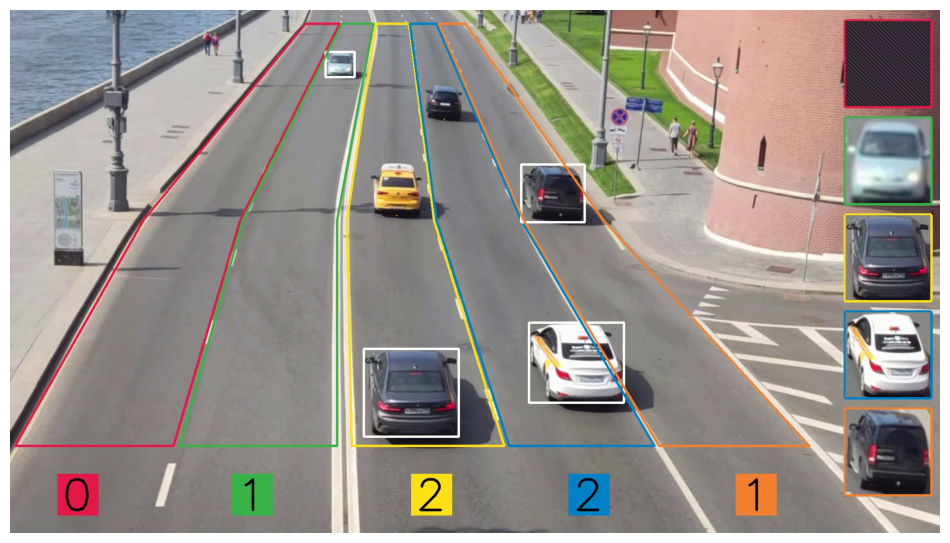

In [12]:
for i, frame in enumerate(iterator):
    if i == 350:
        plot_image(frame)
        break